In [57]:
%matplotlib widget

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from itertools import combinations

filename = "HatsopoulosReachTask"
data = sp.io.loadmat(filename)

In [2]:
for k in data.keys():
    print(k)

__header__
__version__
__globals__
direction
dt
numNeurons
goTime
cueTime
numTimebins
numTrials
brainRegion
firingRate


In [70]:
data['firingRate'].shape

(143, 30, 158)

In [3]:
firing_rate = data['firingRate']
direction = np.squeeze(data['direction'])

directions = np.unique(direction)

rate_by_direction = [np.mean(firing_rate[:, :, direction==d], axis=2) for d in directions]

print(firing_rate.shape, direction.shape)
print([r.shape for r in rate_by_direction])
print(directions)

(143, 30, 158) (158,)
[(143, 30), (143, 30), (143, 30), (143, 30), (143, 30), (143, 30), (143, 30), (143, 30)]
[1 2 3 4 5 6 7 8]


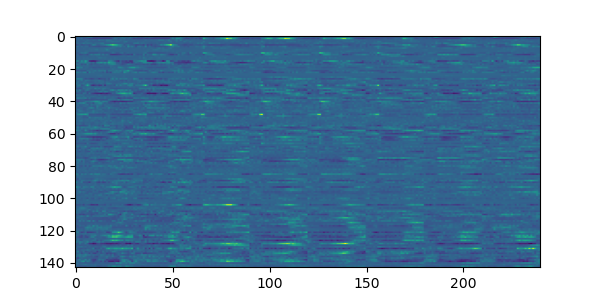

In [24]:
activity = np.concatenate(rate_by_direction, axis=1)
centered_activity = activity - np.mean(activity, axis=1, keepdims=True)
col_centered_activity = activity - np.mean(activity, axis=0, keepdims=True)

fig = plt.figure(figsize=(6, 3))
plt.imshow(centered_activity, aspect='auto')
plt.show()

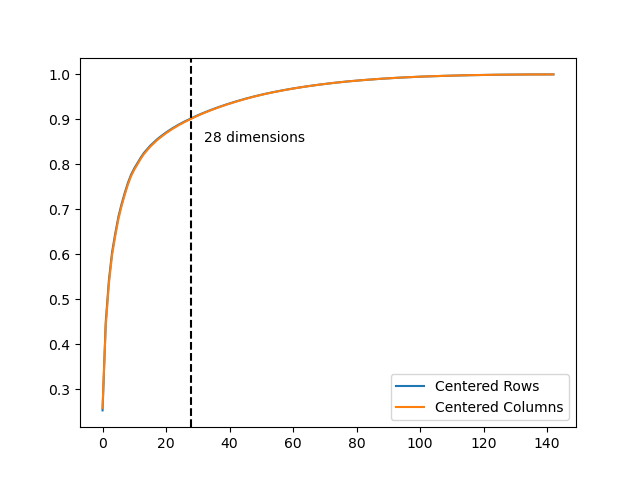

In [38]:
def pca(data, with_row_center=True):
    if with_row_center:
        udata = data - np.mean(data, axis=1, keepdims=True)
        cov = udata @ udata.T / (data.shape[1] - 1)
    else:
        cov = data @ data.T / (data.shape[1] - 1)
    evals, evecs = np.linalg.eigh(cov)
    evals = evals[::-1]
    evecs = evecs[:, ::-1]
    return evals, evecs

evals, evecs = pca(centered_activity)
col_evals, col_evecs = pca(col_centered_activity)

cumvar = np.cumsum(evals / np.sum(evals))
idx90 = np.where(cumvar > 0.9)[0][0]

col_cumvar = np.cumsum(col_evals / np.sum(col_evals))
col_idx90 = np.where(col_cumvar > 0.9)[0][0]

fig = plt.figure()
plt.plot(cumvar, label="Centered Rows")
plt.plot(col_cumvar, label="Centered Columns")
plt.axvline(idx90, color='k', linestyle='--')
plt.text(idx90+4, 0.85, f"{idx90} dimensions")
plt.legend()
plt.show()

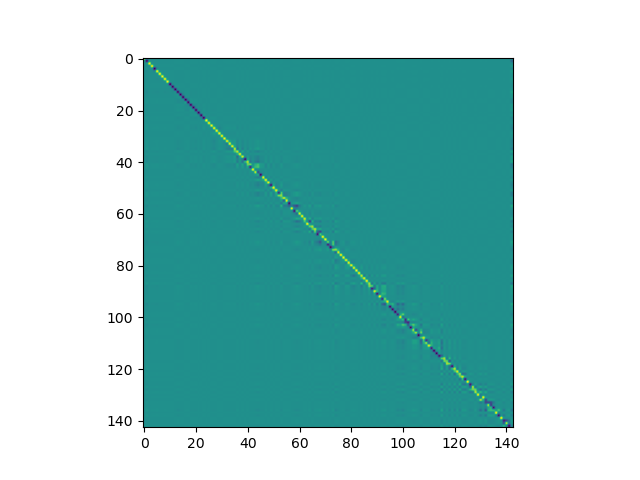

In [37]:
fig = plt.figure()
plt.imshow(evecs.T @ col_evecs)
plt.show()

(3, 240) (3, 8, 30)


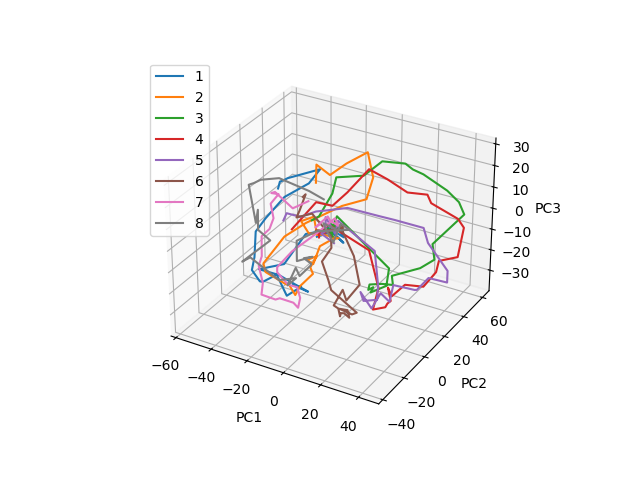

In [53]:
scores = evecs.T[:3, :] @ centered_activity
scores_by_direction = scores.reshape((3, len(directions), -1))

print(scores.shape, scores_by_direction.shape)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i, d in enumerate(directions):
    ax.plot(scores_by_direction[0, i], scores_by_direction[1, i], scores_by_direction[2, i], label=d)
plt.xlabel('PC1')
plt.ylabel('PC2')
ax.set_zlabel('PC3')
plt.legend()
plt.show()

(3, 240) (3, 8, 30)


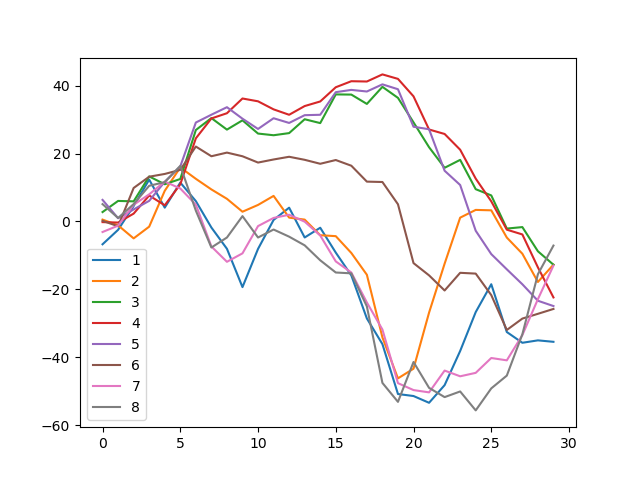

In [105]:
scores = evecs.T[:3, :] @ centered_activity
scores_by_direction = scores.reshape((3, len(directions), -1))

print(scores.shape, scores_by_direction.shape)

fig = plt.figure()
ax = fig.add_subplot(111)
for i, d in enumerate(directions):
    ax.plot(scores_by_direction[0, i], label=d)
plt.legend()
plt.show()

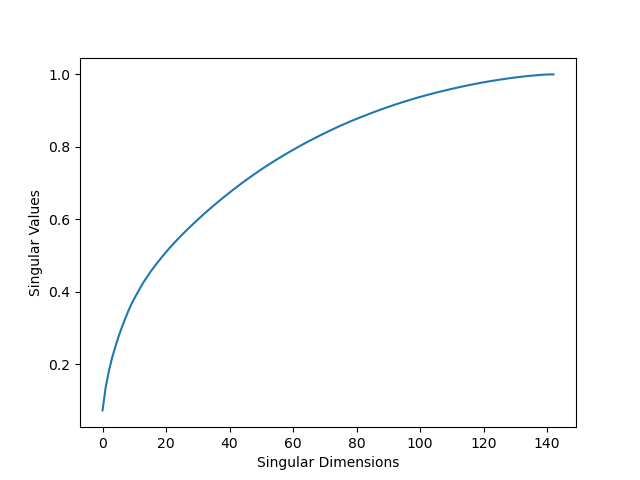

In [49]:
U, S, Vt = np.linalg.svd(centered_activity, full_matrices=False)

cum_svs = np.cumsum(S / np.sum(S))

fig = plt.figure()
plt.plot(cum_svs)
plt.xlabel('Singular Dimensions')
plt.ylabel('Singular Values')
plt.show()

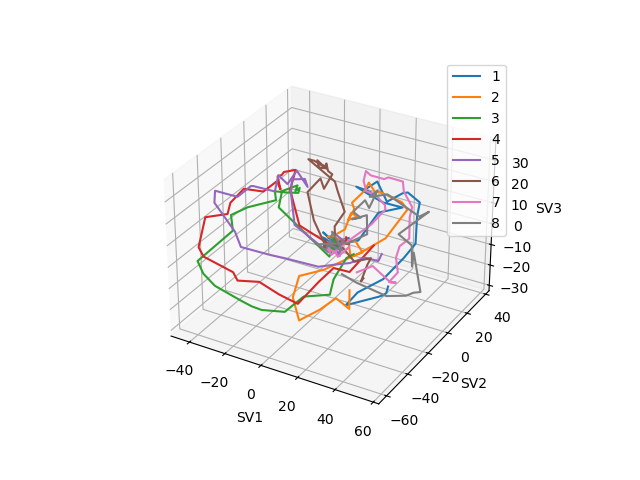

In [55]:
left_scores = U.T[:3, :] @ centered_activity
right_scores = centered_activity @ Vt.T[:, :3]

left_scores_by_direction = left_scores.reshape((3, len(directions), -1))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i, d in enumerate(directions):
    ax.plot(left_scores_by_direction[0, i], left_scores_by_direction[1, i], left_scores_by_direction[2, i], label=d)
plt.xlabel('SV1')
plt.ylabel('SV2')
ax.set_zlabel('SV3')
plt.legend()
plt.show()

In [80]:
def generate_combinations(items, r):
    return list(map(np.array, combinations(items, r)))

target_combos = generate_combinations(directions, 4)

mean_by_direction = [np.mean(firing_rate[:, :, direction==d], axis=1) for d in directions]
trial_activity = np.concatenate(mean_by_direction, axis=1)

idx_combo = 1
target = 2*np.isin(direction, target_combos[idx_combo]) - 1

In [110]:
from sklearn.model_selection import train_test_split

def split_get_indices_equally(y, test_size=0.5, random_state=None):
    # Get unique values and their counts
    unique_y = np.unique(y)
    
    # Create a dictionary to store indices for each unique value
    index_dict = {val: np.where(y == val)[0] for val in unique_y}
    
    train_indices = []
    test_indices = []
    
    for val in unique_y:
        val_indices = index_dict[val]
        
        # Split indices for this value
        val_train, val_test = train_test_split(
            val_indices, 
            test_size=test_size, 
            random_state=random_state
        )
        
        train_indices.extend(val_train)
        test_indices.extend(val_test)
    
    # Convert to numpy arrays and sort
    train_indices = np.sort(train_indices)
    test_indices = np.sort(test_indices)
    
    # Create train and test sets
    y_train = y[train_indices]
    y_test = y[test_indices]
    
    return y_train, y_test, train_indices, test_indices

def linear_regression(x, y, cv=True):
    if cv:
        y_train, y_test, train_indices, test_indices = split_get_indices_equally(y, test_size=0.5)
        x_train = x[:, train_indices]
        x_test = x[:, test_indices]
    else:
        x_train = np.copy(x)
        y_train = np.copy(y)
        x_test = np.copy(x)
        y_test = np.copy(y)

    X_train = np.concatenate([np.ones((x_train.shape[1], 1)), x_train.T], axis=1) # add intercept term
    beta = np.linalg.pinv(X_train.T @ X_train) @ X_train.T @ y_train.T

    X_test = np.concatenate([np.ones((x_test.shape[1], 1)), x_test.T], axis=1) # add intercept term
    pred = beta @ X_test.T
    guess = 2*(pred > 0)-1
    correct_fraction = np.sum(guess == y_test) / y_test.size
    return beta, guess, correct_fraction

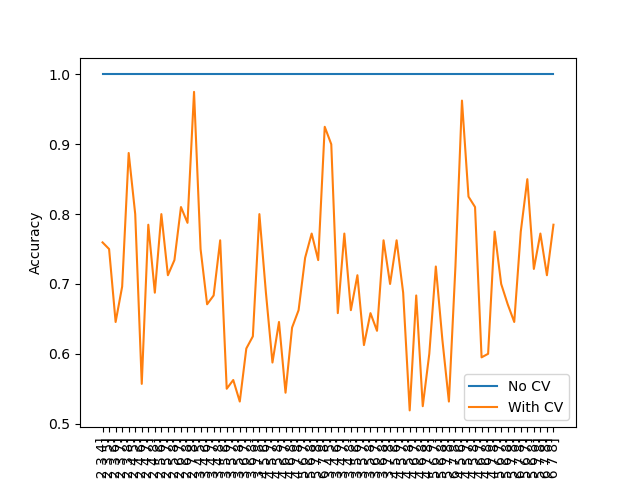

In [111]:
accuracy = []
cv_accuracy = []
for target_combo in target_combos:
    target = 2*np.isin(direction, target_combo) - 1
    beta, guess, correct_fraction = linear_regression(trial_activity, target, cv=False)
    accuracy.append(correct_fraction)
    beta, guess, correct_fraction = linear_regression(trial_activity, target, cv=True)
    cv_accuracy.append(correct_fraction)

fig = plt.figure()
plt.plot(accuracy, label="No CV")
plt.plot(cv_accuracy, label="With CV")
plt.xticks(range(len(target_combos)), [f"{c}" for c in target_combos], rotation=90)
plt.ylabel('Accuracy')
plt.legend()
plt.show()